In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import warnings
# suppress warnings
warnings.filterwarnings("ignore")

# Basics
import arviz as az  # Visualization
import pytensor  # Graph-based tensor library
import hssm
from ssms.basic_simulators.simulator import simulator
import ssms
from pptx import Presentation
from pptx.util import Inches
# import ssms.basic_simulators # Model simulators
import hddm_wfpt
import bambi as bmb

# Setting float precision in pytensor
pytensor.config.floatX = "float32"

import jax
jax.config.update("jax_enable_x64", False)

import src.utils.setup_figures as figures
import src.utils.basic as utils


jax.devices()

[CudaDevice(id=0), CudaDevice(id=1)]

In [21]:
from config import dir_config, main_config

base_data_dir = Path(dir_config.data.base)
raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)

data = pd.read_csv(Path(processed_dir, "processed_data60accu_allowed.csv"), index_col=None)
processed_metadata = pd.read_csv(Path(processed_dir, "processed_metadata_60accu_allowed.csv"), index_col=None)

# exclude the following subjects where categorization score is more than 2
reject_subs = processed_metadata.loc[processed_metadata["categorization_score"] > 2]['subject_id']
processed_metadata = processed_metadata.loc[~processed_metadata["subject_id"].isin(reject_subs)]
processed_data = data.loc[~data["subject"].isin(reject_subs)]


## Model

In [22]:
processed_data.head()                                           

,subject,medication,prior,prior_direction,prior_color,color,coherence,target,is_valid,outcome,choice,reaction_time,session_name,signed_coherence
0,CG,off,rl,left,red,1,100.0,1,True,True,1,626.976669,Brady_CG_OFFmeds_rl.mat,100.0
1,CG,off,rl,left,red,-1,0.0,1,True,False,-1,945.801775,Brady_CG_OFFmeds_rl.mat,0.0
2,CG,off,rl,left,red,-1,0.0,-1,True,False,1,964.249405,Brady_CG_OFFmeds_rl.mat,-0.0
3,CG,off,rl,left,red,-1,100.0,-1,True,True,-1,671.215080,Brady_CG_OFFmeds_rl.mat,-100.0
4,CG,off,rl,left,red,-1,0.0,1,True,True,1,1046.959465,Brady_CG_OFFmeds_rl.mat,0.0


### Loading Dataset

processed_data  
&ensp;&ensp;color: &ensp;&ensp;&ensp;&ensp;&ensp;{prior: 1, equal: -1}  
&ensp;&ensp;direction: &ensp;&ensp;{prior: 1, equal: -1}

In [23]:
data = pd.DataFrame(
    {
        "rt": processed_data["reaction_time"]/1000,
        "response": processed_data["choice"],
        "stimulus": processed_data["signed_coherence"]/100,
        "color": processed_data["color"].astype("category"),
        "treatment": processed_data["medication"].replace({"off": 0, "on": 1}).astype("category"),
        "subject": processed_data["subject"].astype("category"),
    }
)

### Weibull Model

In [24]:
def get_weibull_model(data):
    weibull_model = hssm.HSSM(
        data = data,
        model = "weibull",
        include = [
            {
                "name": "v",
                # "prior": {
                #     "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                #     "stimulus":  {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                #     "treatment":  {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                #     "subject":  {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                # },
                "formula": "v ~ (stimulus|C(treatment)*C(color)*C(subject))", # how does slope and offset changes with treatment and color
                "link": "identity",
                "bounds": (-3.0, 3.0),
            },
            {
                "name": "a",
                # "prior": {"Intercept": {"name": "Uniform", "lower": 0.5, "upper": 3.0},},
                "formula": "a ~ (C(treatment)*C(color)*C(subject))",
            },
            {
                "name": "z",
                # "prior": {"Intercept": {"name": "Uniform", "lower": 0.1, "upper": 0.9},},
                "formula": "z ~ C(subject))", #(C(treatment)*C(subject))",
            },
            {
                "name": "t",
                # "prior": {"Intercept": {"name": "Uniform", "lower": 0.1, "upper": 0.9},}, 
                "formula": "t ~ C(subject))", #(C(treatment)*C(subject))",
            },
            {
                "name": "alpha",
                # "prior": {"Intercept": {"name": "Uniform", "lower": 0.1, "upper": 0.9},},
                "formula": "alpha ~ C(subject))", #(C(treatment)*C(subject))",
            },
            {
                "name": "beta",
                # "prior": {"Intercept": {"name": "Uniform", "lower": 0.1, "upper": 0.9},}, 
                "formula": "beta ~ C(subject))", #(C(treatment)*C(subject)))",
            },
        ],
    )
    return weibull_model


Model initialized successfully.


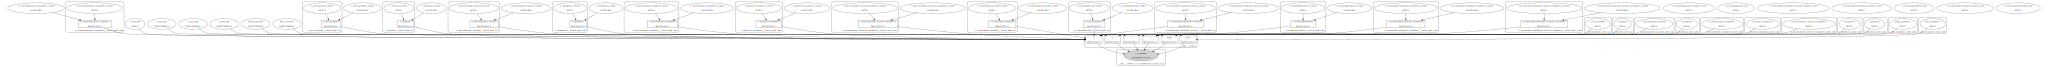

In [25]:
weibull_full_model = get_weibull_model(data)
weibull_full_model.graph()

In [ ]:
# idata_weibull_full_model = weibull_full_model.sample(sampler="nuts_numpyro", chains=5, cores=2, draws=4000, tune=3000, target_accept=0.95)
idata_weibull_full_model = weibull_full_model.sample(sampler="nuts_numpyro", chains=2, cores=4, draws=500, tune=500)


Using default initvals. 



sample: 100%|██████████| 1000/1000 [07:26<00:00,  2.24it/s, 13 steps of size 9.26e-04. acc. prob=0.77] 
There were 2000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 2000/2000 [00:03<00:00, 600.78it/s]


array([[<Axes: title={'center': 'v_stimulus|C(color):C(subject)_sigma'}>,
        <Axes: title={'center': 'v_stimulus|C(color):C(subject)_sigma'}>],
       [<Axes: title={'center': 'v_stimulus|C(color)_offset'}>,
        <Axes: title={'center': 'v_stimulus|C(color)_offset'}>],
       [<Axes: title={'center': 'v_1|C(treatment):C(color):C(subject)_offset'}>,
        <Axes: title={'center': 'v_1|C(treatment):C(color):C(subject)_offset'}>],
       [<Axes: title={'center': 'v_stimulus|C(treatment)_sigma'}>,
        <Axes: title={'center': 'v_stimulus|C(treatment)_sigma'}>],
       [<Axes: title={'center': 'v_1|C(color)'}>,
        <Axes: title={'center': 'v_1|C(color)'}>],
       [<Axes: title={'center': 'a_Intercept'}>,
        <Axes: title={'center': 'a_Intercept'}>],
       [<Axes: title={'center': 'v_stimulus|C(subject)_sigma'}>,
        <Axes: title={'center': 'v_stimulus|C(subject)_sigma'}>],
       [<Axes: title={'center': 'a_C(treatment):C(color):C(subject)'}>,
        <Axes: title=

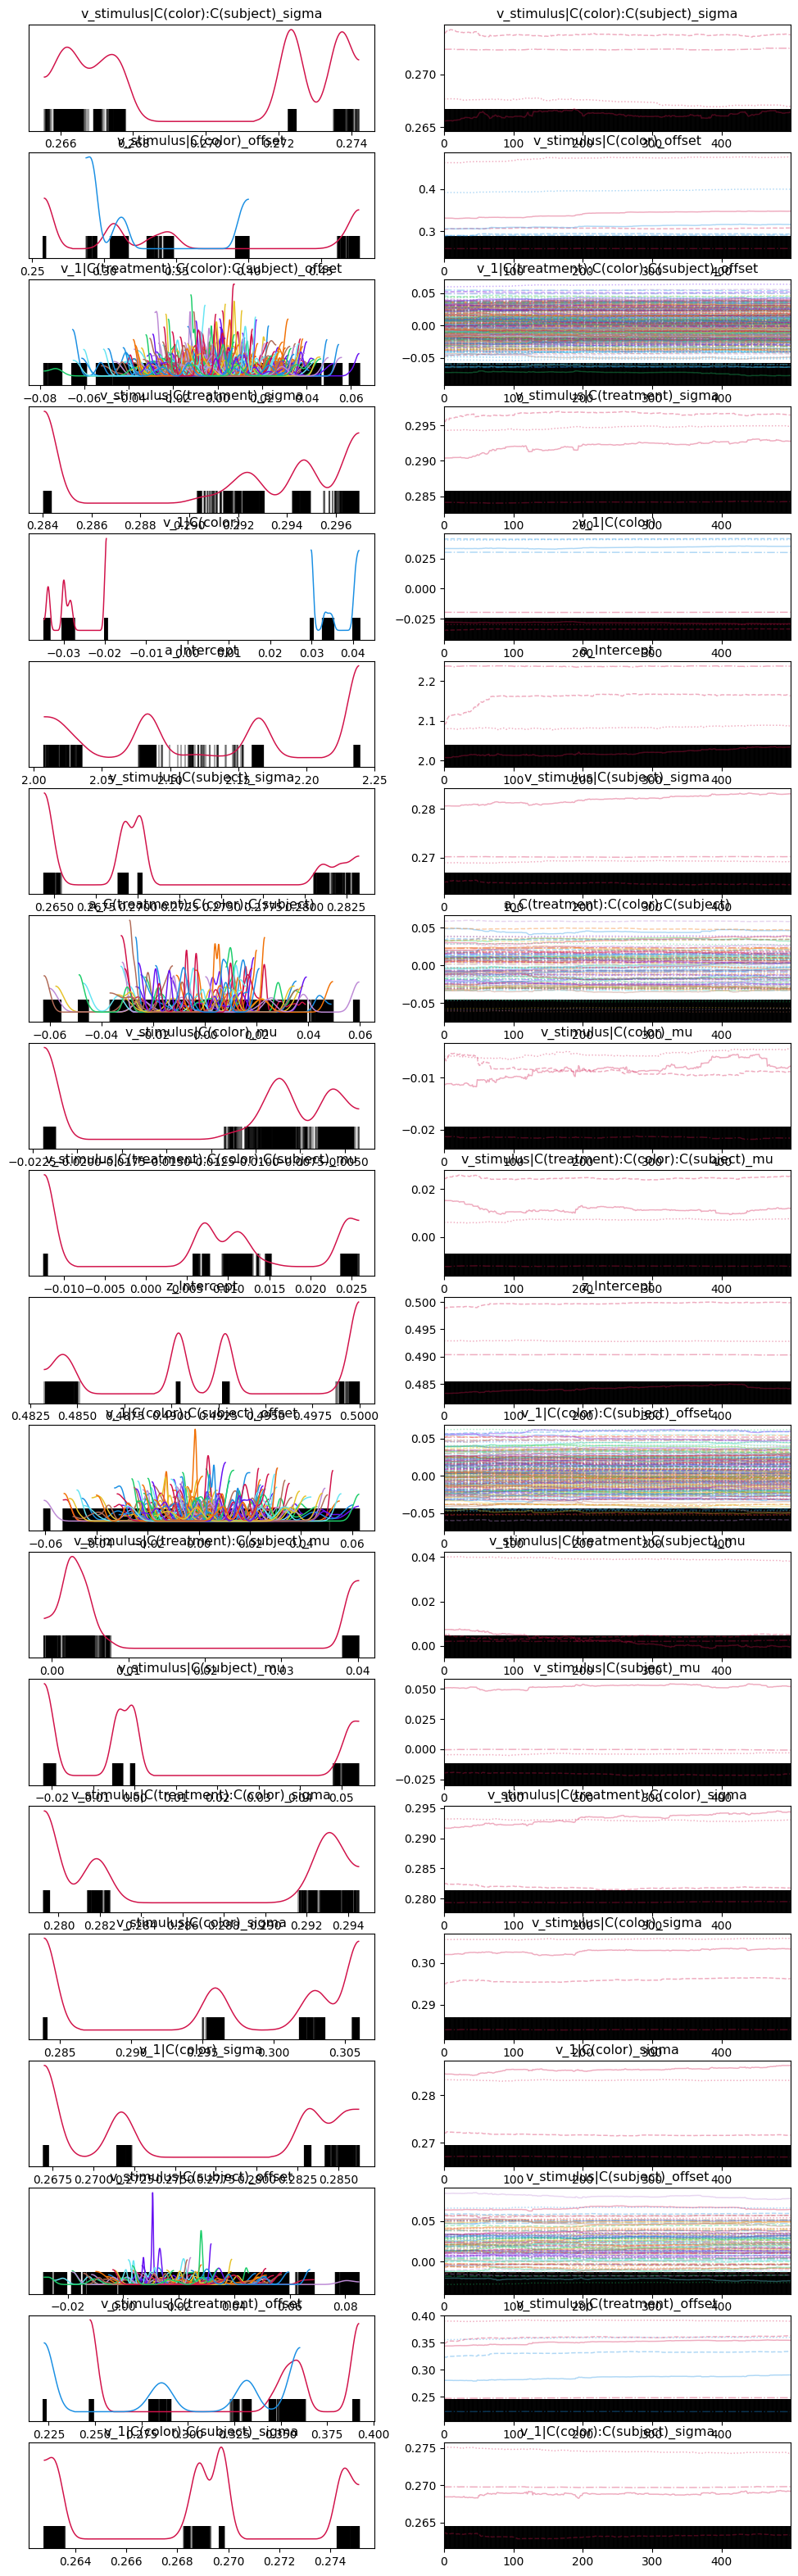

In [28]:
az.plot_trace(idata_weibull_full_model, combined=True, compact=True)